In [ ]:
import multiprocessing
import threading                    # رویکردی شی گرا برای ایجاد نخ
import tensorflow as tf             #جهت ساخت شبکه های عصبی
import numpy as np
import gym
import os
import shutil
import matplotlib.pyplot as plt      # جهت ترسیم نمودار
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
OUTPUT_GRAPH = True
LOG_DIR = './log'
N_WORKERS = multiprocessing.cpu_count()   # workerتعداد عامل های 
MAX_EP_STEP = 200                         #حداکثر تعداد گام در هر قسمت 
MAX_GLOBAL_EP = 200                      #تعداد کل قسمتها 
GLOBAL_NET_SCOPE = 'Global_Net'
UPDATE_GLOBAL_ITER = 10                   #تعیین تعداد دفعات بروزرسانی شبکه جهانی  
GAMMA = 0.9                               # ضریب تخفیف
ENTROPY_BETA = 0.01                       # ضریب انتروپی
LR_A = 0.0001                             # نرخ یادگیری بازیگر 
LR_C = 0.001                              # نرخ یادگیری نقاد
GLOBAL_EP = 0
GLOBAL_RUNNING_R = []

# boolean for rendering the environment
render=False 
# directory for storing logs
log_dir = 'logs'

In [ ]:
GAME = 'MountainCarContinuous-v0'
env = gym.make(GAME)
N_S = env.observation_space.shape[0]                      # تعداد حالات 
N_A = env.action_space.shape[0]                           # تعداد اعمال
A_BOUND = [env.action_space.low, env.action_space.high]   # محدوده اعمال

In [ ]:
class ACNet(object):
  def __init__(self, scope, globalAC=None):
    if scope == GLOBAL_NET_SCOPE:
      with tf.variable_scope(scope):
        self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
        self.a_params, self.c_params = self._build_net(scope)[-2:]
    else:
      with tf.variable_scope(scope):
        self.s = tf.placeholder(tf.float32, [None, N_S], 'S')
        self.a_his = tf.placeholder(tf.float32, [None, N_A], 'A')
        self.v_target = tf.placeholder(tf.float32, [None, 1], 'Vtarget')
        mu, sigma, self.v, self.a_params, self.c_params = self._build_net(scope)
        td = tf.subtract(self.v_target, self.v, name='TD_error')
        with tf.name_scope('c_loss'):
          self.c_loss = tf.reduce_mean(tf.square(td))
        with tf.name_scope('wrap_a_out'):
          mu, sigma = mu * A_BOUND[1], sigma + 1e-4
        normal_dist = tf.distributions.Normal(mu, sigma)
        with tf.name_scope('a_loss'):
          log_prob = normal_dist.log_prob(self.a_his)
          exp_v = log_prob * tf.stop_gradient(td)
          entropy = normal_dist.entropy()
          self.exp_v = ENTROPY_BETA * entropy + exp_v
          self.a_loss = tf.reduce_mean(-self.exp_v)
        with tf.name_scope('choose_a'):
          self.A = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=[0, 1]), A_BOUND[0], A_BOUND[1])
        with tf.name_scope('local_grad'):
          self.a_grads = tf.gradients(self.a_loss, self.a_params)
          self.c_grads = tf.gradients(self.c_loss, self.c_params)
      with tf.name_scope('sync'):
        with tf.name_scope('pull'):
          self.pull_a_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.a_params, globalAC.a_params)]
          self.pull_c_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.c_params, globalAC.c_params)]
        with tf.name_scope('push'):
          self.update_a_op = OPT_A.apply_gradients(zip(self.a_grads, globalAC.a_params))
          self.update_c_op = OPT_C.apply_gradients(zip(self.c_grads, globalAC.c_params))
  def _build_net(self, scope):
    w_init = tf.random_normal_initializer(0., .1)
    with tf.variable_scope('actor'):
      l_a = tf.layers.dense(self.s, 200, tf.nn.relu6, kernel_initializer=w_init, name='la')
      mu = tf.layers.dense(l_a, N_A, tf.nn.tanh, kernel_initializer=w_init, name='mu')
      sigma = tf.layers.dense(l_a, N_A, tf.nn.softplus, kernel_initializer=w_init, name='sigma')
    with tf.variable_scope('critic'):
      l_c = tf.layers.dense(self.s, 100, tf.nn.relu6, kernel_initializer=w_init, name='lc')
      v = tf.layers.dense(l_c, 1, kernel_initializer=w_init, name='v')
    a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/actor')
    c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope + '/critic')
    return mu, sigma, v, a_params, c_params
  def update_global(self, feed_dict):
    SESS.run([self.update_a_op, self.update_c_op], feed_dict)
  def pull_global(self): 
    SESS.run([self.pull_a_params_op, self.pull_c_params_op])
  def choose_action(self, s):
    s = s[np.newaxis, :]
    return SESS.run(self.A, {self.s: s})

In [ ]:
class Worker(object):
  def __init__(self, name, globalAC):
    self.env = gym.make(GAME).unwrapped
    self.name = name
    self.AC = ACNet(name, globalAC)
  def work(self):
    global GLOBAL_RUNNING_R, GLOBAL_EP
    total_step = 1
    buffer_s, buffer_a, buffer_r = [], [], []
    while not COORD.should_stop() and GLOBAL_EP < MAX_GLOBAL_EP:
      s = self.env.reset()
      ep_r = 0
      for ep_t in range(MAX_EP_STEP):
        a = self.AC.choose_action(s)
        s_, r, done, info = self.env.step(a)
        done = True if ep_t == MAX_EP_STEP - 1 else False
        ep_r += r
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append((r+8)/8)
        if total_step % UPDATE_GLOBAL_ITER == 0 or done:
          if done:
            v_s_ = 0
          else:
            v_s_ = SESS.run(self.AC.v, {self.AC.s: s_[np.newaxis, :]})[0, 0]
          buffer_v_target = []
          for r in buffer_r[::-1]:
            v_s_ = r + GAMMA * v_s_
            buffer_v_target.append(v_s_)
          buffer_v_target.reverse()
          buffer_s, buffer_a, buffer_v_target = np.vstack(buffer_s), np.vstack(buffer_a), np.vstack(buffer_v_target)
          feed_dict = {
              self.AC.s: buffer_s,
              self.AC.a_his: buffer_a,
              self.AC.v_target: buffer_v_target,
              }
          self.AC.update_global(feed_dict)
          buffer_s, buffer_a, buffer_r = [], [], []
          self.AC.pull_global()
        s = s_
        total_step += 1
        if done:
          if len(GLOBAL_RUNNING_R) == 0:
            GLOBAL_RUNNING_R.append(ep_r)
          else:
            GLOBAL_RUNNING_R.append(0.9 * GLOBAL_RUNNING_R[-1] + 0.1 * ep_r)
          print(
              self.name,
              "Ep:", GLOBAL_EP,
              "| Ep_r: %i" % GLOBAL_RUNNING_R[-1],
                )
          GLOBAL_EP += 1
          break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense`

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W_0 Ep: 0 | Ep_r: -9
W_1 Ep: 1 | Ep_r: -9
W_0 Ep: 2 | Ep_r: -8
W_1 Ep: 3 | Ep_r: -8
W_0 Ep: 4 | Ep_r: -8
W_1 Ep: 5 | Ep_r: -8
W_0 Ep: 6 | Ep_r: -8
W_1 Ep: 7 | Ep_r: -8
W_0 Ep: 8 | Ep_r: -8
W_1 Ep: 9 | Ep_r: -7
W_0 Ep: 10 | Ep_r: -7
W_1 Ep: 11 | Ep_r: -7
W_0 Ep: 12 | Ep_r: -7
W_1 Ep: 13 | Ep_r: -7
W_0 Ep: 14 | Ep_r: -7
W_1 Ep: 15 | Ep_r: -7
W_0 Ep: 16 | Ep_r: -7
W_1 Ep: 17 | Ep_r: -7
W_1 Ep: 18 | Ep_r: -7
W_

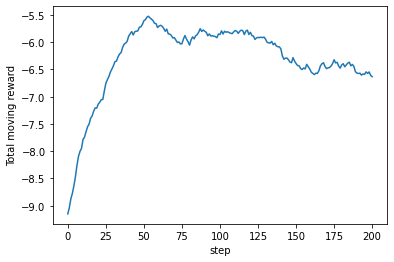

In [ ]:
if __name__ == "__main__":
  SESS = tf.Session()
  with tf.device("/cpu:0"):
    OPT_A = tf.train.RMSPropOptimizer(LR_A, name='RMSPropA')
    OPT_C = tf.train.RMSPropOptimizer(LR_C, name='RMSPropC')
    GLOBAL_AC = ACNet(GLOBAL_NET_SCOPE)
    workers = []
    for i in range(N_WORKERS):
      i_name = 'W_%i' % i
      workers.append(Worker(i_name, GLOBAL_AC))
  COORD = tf.train.Coordinator()
  SESS.run(tf.global_variables_initializer())
  if OUTPUT_GRAPH:
    if os.path.exists(LOG_DIR):
      shutil.rmtree(LOG_DIR)
    tf.summary.FileWriter(LOG_DIR, SESS.graph)
  worker_threads = []
  for worker in workers:
    job = lambda: worker.work()
    t = threading.Thread(target=job)
    t.start()
    worker_threads.append(t)
  COORD.join(worker_threads)
  plt.plot(np.arange(len(GLOBAL_RUNNING_R)), GLOBAL_RUNNING_R)
  plt.xlabel('step')
  plt.ylabel('Total moving reward')
  plt.show()